In [1]:
# Core Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tempfile import TemporaryDirectory
from tqdm import tqdm

# PyTorch and Torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

# Sklearn for metrics and splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

# KaggleHub: for fetching datasets easily
import kagglehub

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)
cudnn.benchmark = True  # Speed up training when input sizes are consistent

In [2]:
# Download dataset
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage-dataset


In [3]:
dir_path = "/kaggle/input/plantvillage-dataset/color"

In [4]:
# Collect image data and labels
data = []
label_names = []
distinct_labels = set()

# Traverse through the dataset directories
for crop_type in os.listdir(dir_path):
    crop_path = os.path.join(dir_path, crop_type)
    for image_file in os.listdir(crop_path):
        image_path = os.path.join(crop_path, image_file)
        image = np.asarray(Image.open(image_path))
        
        # Ensure the image is RGB and of expected shape
        if image.shape == (256, 256, 3):
            data.append(image)
            label_names.append(crop_type)
            distinct_labels.add(crop_type)

# Convert to numpy arrays
data = np.array(data)
label_names = np.array(label_names)
distinct_labels = sorted(distinct_labels)

In [5]:
# Display the shape of the data and labels arrays
print("Image data shape:", data.shape)
print("Label names shape:", label_names.shape)

Image data shape: (54304, 256, 256, 3)
Label names shape: (54304,)


In [6]:
# Convert label names to numeric indices
labels = [distinct_labels.index(name) for name in label_names]
labels = np.array(labels, dtype=np.int64)

# Display numeric labels
print("Numeric labels:", labels)

Numeric labels: [30 30 30 ... 10 10 10]


In [7]:
# Check CUDA availability
is_cuda_available = torch.cuda.is_available()
print("CUDA Available:", is_cuda_available)

CUDA Available: True


In [8]:
# Split data into training and validation sets (80% train, 20% temp)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.20, random_state=42)

# Further split validation set into validation and test (10% of total for test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.10, random_state=42)

In [9]:
class PlantVillageDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [10]:
# Data augmentation and preprocessing
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=180),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

# Data loaders
loaders = {
    'train': DataLoader(
        PlantVillageDataset(X_train, y_train, transform=data_transforms['train']),
        shuffle=True,
        batch_size=32
    ),
    'val': DataLoader(
        PlantVillageDataset(X_val, y_val, transform=data_transforms['val']),
        shuffle=True,
        batch_size=32
    ),
    'test': DataLoader(
        PlantVillageDataset(X_test, y_test, transform=data_transforms['val']),
        shuffle=True,
        batch_size=32
    )
}

# Dataset stats and environment
dataset_sizes = {
    'train': len(X_train),
    'val': len(X_val),
    'test': len(X_test)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
losses = {'train': [], 'val': []}
accs = {'train': [], 'val': []}

In [11]:
def train(model, criterion, optimizer, scheduler):
    model.train()
    total_loss = 0.0
    total_correct = 0

    for inputs, labels in tqdm(loaders['train'], desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.enable_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total_correct += torch.sum(preds == labels)

    scheduler.step()

    train_loss = total_loss / dataset_sizes['train']
    train_acc = total_correct.cpu().item() / dataset_sizes['train']

    losses['train'].append(train_loss)
    accs['train'].append(train_acc)

    return train_loss, train_acc

In [12]:
def val(model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0

    for inputs, labels in loaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)

        total_loss += loss.item() * inputs.size(0)
        total_correct += torch.sum(preds == labels)

    val_loss = total_loss / dataset_sizes['val']
    val_acc = total_correct.cpu().item() / dataset_sizes['val']

    losses['val'].append(val_loss)
    accs['val'].append(val_acc)

    return val_loss, val_acc

In [13]:
def test(model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    true_labels = []
    pred_labels = []

    for inputs, labels in loaders['test']:
        inputs = inputs.to(device)
        true_labels.extend(labels.numpy())
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            pred_labels.extend(preds.cpu().numpy())
            loss = criterion(outputs, labels)

        total_loss += loss.item() * inputs.size(0)
        total_correct += torch.sum(preds == labels)

    test_loss = total_loss / dataset_sizes['test']
    test_acc = total_correct.cpu().item() / dataset_sizes['test']
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

    return test_loss, test_acc, conf_matrix, precision, recall, f1

In [14]:
# Load pre-trained ResNet-18 model with ImageNet weights
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s] 


In [15]:
# Replace the final layer to match the number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(distinct_labels))
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
# Ensure directory exists for saving model parameters
os.makedirs("resnetcheckpoints", exist_ok=True)

# Training configuration
num_epochs = 25
best_model_params_path = "resnetcheckpoints/best_model_params.pt"
best_acc = 0.0

# Save initial model state
torch.save(model.state_dict(), best_model_params_path)

# Training loop
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}')
    print('-' * 30)

    train_loss, train_acc = train(model, criterion, optimizer, scheduler)
    val_loss, val_acc = val(model, criterion)

    print(f'Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f} | Acc: {val_acc:.4f}')

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch': epoch,
            'best_acc': best_acc,
        }, 'resnetcheckpoints/checkpoint.pt')

print(f'\nBest Validation Accuracy Achieved: {best_acc:.4f}')


Epoch 1/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:09<00:00,  2.78it/s]


Train Loss: 0.5545 | Acc: 0.8269
Validation Loss: 0.3308 | Acc: 0.8869

Epoch 2/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:02<00:00,  2.82it/s]


Train Loss: 0.2698 | Acc: 0.9108
Validation Loss: 0.2036 | Acc: 0.9320

Epoch 3/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:02<00:00,  2.81it/s]


Train Loss: 0.1982 | Acc: 0.9357
Validation Loss: 0.1797 | Acc: 0.9412

Epoch 4/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:02<00:00,  2.82it/s]


Train Loss: 0.1744 | Acc: 0.9419
Validation Loss: 0.1825 | Acc: 0.9432

Epoch 5/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:10<00:00,  2.77it/s]


Train Loss: 0.1524 | Acc: 0.9496
Validation Loss: 0.0791 | Acc: 0.9726

Epoch 6/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:03<00:00,  2.81it/s]


Train Loss: 0.1311 | Acc: 0.9557
Validation Loss: 0.1519 | Acc: 0.9527

Epoch 7/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:03<00:00,  2.81it/s]


Train Loss: 0.1148 | Acc: 0.9620
Validation Loss: 0.1371 | Acc: 0.9547

Epoch 8/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:02<00:00,  2.81it/s]


Train Loss: 0.0511 | Acc: 0.9835
Validation Loss: 0.0255 | Acc: 0.9907

Epoch 9/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:09<00:00,  2.77it/s]


Train Loss: 0.0349 | Acc: 0.9878
Validation Loss: 0.0219 | Acc: 0.9922

Epoch 10/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:01<00:00,  2.82it/s]


Train Loss: 0.0307 | Acc: 0.9900
Validation Loss: 0.0190 | Acc: 0.9932

Epoch 11/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:00<00:00,  2.83it/s]


Train Loss: 0.0272 | Acc: 0.9908
Validation Loss: 0.0182 | Acc: 0.9938

Epoch 12/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:01<00:00,  2.82it/s]


Train Loss: 0.0257 | Acc: 0.9911
Validation Loss: 0.0175 | Acc: 0.9939

Epoch 13/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:03<00:00,  2.81it/s]


Train Loss: 0.0232 | Acc: 0.9922
Validation Loss: 0.0172 | Acc: 0.9940

Epoch 14/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:07<00:00,  2.79it/s]


Train Loss: 0.0212 | Acc: 0.9930
Validation Loss: 0.0158 | Acc: 0.9946

Epoch 15/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:04<00:00,  2.80it/s]


Train Loss: 0.0182 | Acc: 0.9936
Validation Loss: 0.0138 | Acc: 0.9957

Epoch 16/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:07<00:00,  2.79it/s]


Train Loss: 0.0162 | Acc: 0.9948
Validation Loss: 0.0143 | Acc: 0.9953

Epoch 17/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:03<00:00,  2.81it/s]


Train Loss: 0.0168 | Acc: 0.9950
Validation Loss: 0.0141 | Acc: 0.9954

Epoch 18/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:01<00:00,  2.82it/s]


Train Loss: 0.0149 | Acc: 0.9953
Validation Loss: 0.0133 | Acc: 0.9956

Epoch 19/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:06<00:00,  2.79it/s]


Train Loss: 0.0157 | Acc: 0.9948
Validation Loss: 0.0131 | Acc: 0.9956

Epoch 20/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:05<00:00,  2.80it/s]


Train Loss: 0.0147 | Acc: 0.9952
Validation Loss: 0.0130 | Acc: 0.9956

Epoch 21/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:03<00:00,  2.81it/s]


Train Loss: 0.0142 | Acc: 0.9953
Validation Loss: 0.0133 | Acc: 0.9955

Epoch 22/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:05<00:00,  2.80it/s]


Train Loss: 0.0135 | Acc: 0.9955
Validation Loss: 0.0129 | Acc: 0.9956

Epoch 23/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:05<00:00,  2.80it/s]


Train Loss: 0.0149 | Acc: 0.9951
Validation Loss: 0.0128 | Acc: 0.9956

Epoch 24/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:06<00:00,  2.79it/s]


Train Loss: 0.0143 | Acc: 0.9954
Validation Loss: 0.0131 | Acc: 0.9956

Epoch 25/25
------------------------------


Training: 100%|██████████| 1358/1358 [08:05<00:00,  2.79it/s]


Train Loss: 0.0133 | Acc: 0.9958
Validation Loss: 0.0132 | Acc: 0.9957

Best Validation Accuracy Achieved: 0.9957


In [17]:
test_loss, test_acc, conf_matrix, precision, recall, f1 = test(model, criterion)


📉 Test Loss      : 0.0321
🎯 Test Accuracy  : 0.9963
🔍 Precision      : 0.9966
🔁 Recall         : 0.9963
🎯 F1 Score       : 0.9963


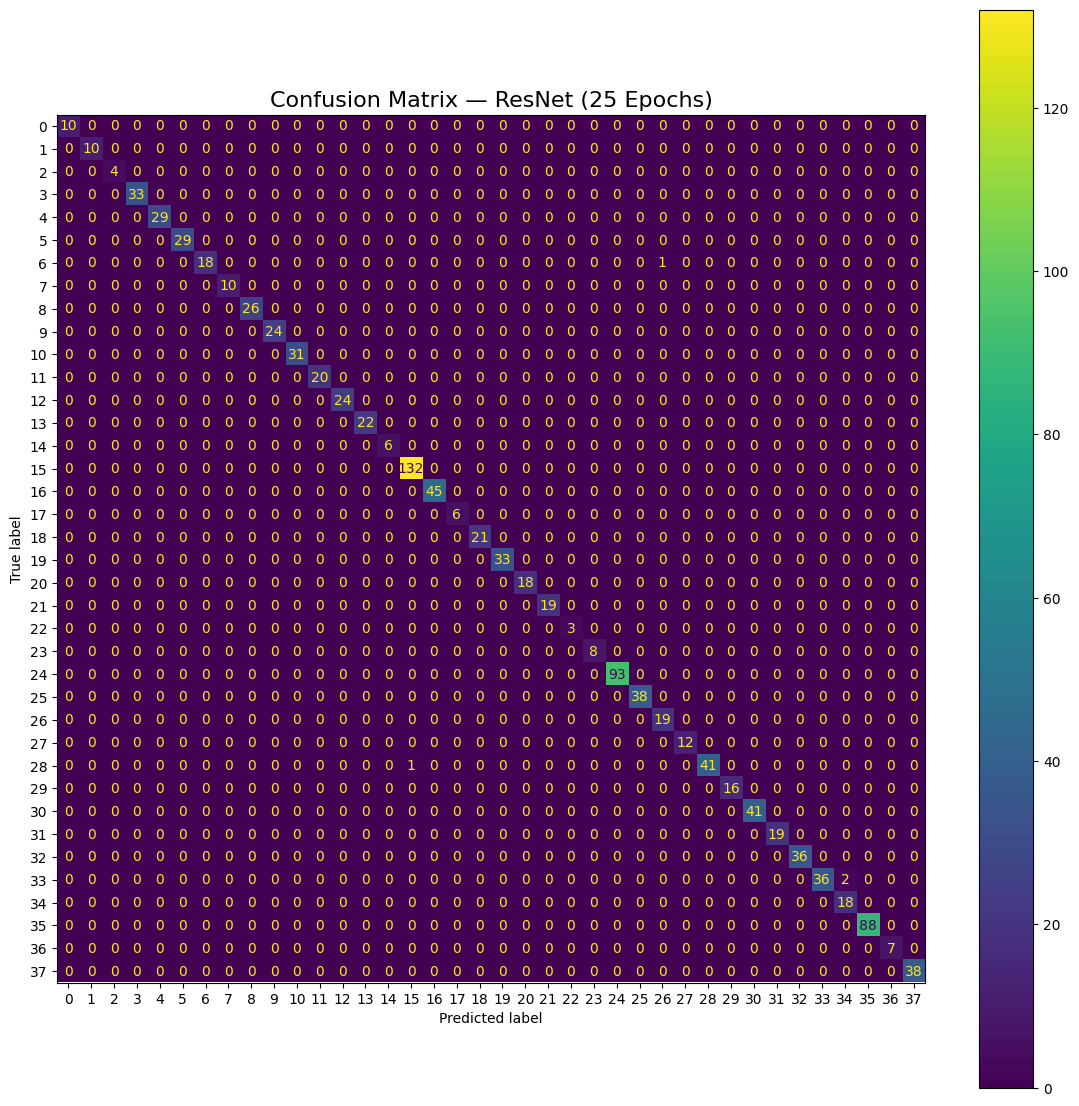

In [19]:
print(f"\n📉 Test Loss      : {test_loss:.4f}")
print(f"🎯 Test Accuracy  : {test_acc:.4f}")
print(f"🔍 Precision      : {precision:.4f}")
print(f"🔁 Recall         : {recall:.4f}")
print(f"🎯 F1 Score       : {f1:.4f}")

# Display confusion matrix with some dignity
os.makedirs("resnet25epochs", exist_ok=True)
cmp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
fig, ax = plt.subplots(figsize=(14, 14))
cmp.plot(ax=ax)
plt.title("Confusion Matrix — ResNet (25 Epochs)", fontsize=16)
plt.savefig("resnet25epochs/confusionmatrix.png")
plt.show()

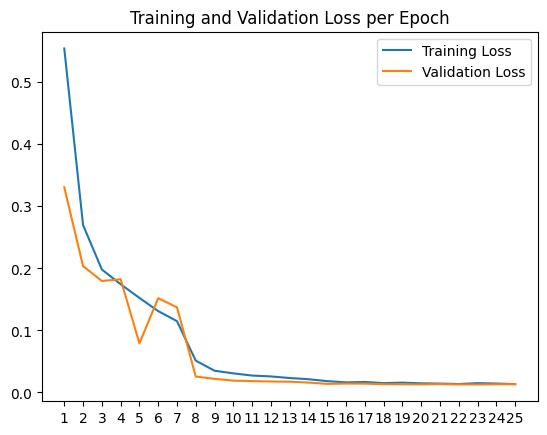

In [20]:
# Plot losses
epochs = [i for i in range(1, num_epochs + 1)]
plt.plot(epochs, losses['train'], label="Training Loss")
plt.plot(epochs, losses['val'], label="Validation Loss")
plt.xticks(epochs)
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.savefig('resnet25epochs/loss.png')
plt.show()

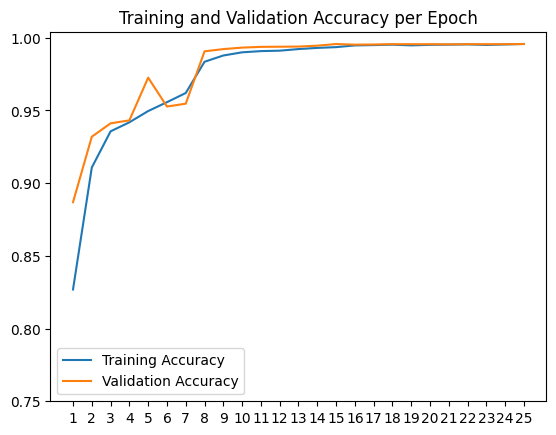

In [21]:
# Plot accuracies
epochs = [i for i in range(1, num_epochs + 1)]
plt.plot(epochs, accs['train'], label="Training Accuracy")
plt.plot(epochs, accs['val'], label="Validation Accuracy")
plt.xticks(epochs)
plt.yticks(np.arange(0.75, 1.02, 0.05))
plt.title("Training and Validation Accuracy per Epoch")
plt.legend()
plt.savefig('resnet25epochs/accuracy.png')
plt.show()

In [25]:
def predict_image(model, image_path):
    model.eval()

    # Define the same transform used for validation
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = image.resize((256, 256))  # Ensure it matches expected size
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)

    # Infer actual class from path (super scientific)
    actual_class = image_path.split("/")[-2]

    predicted_class = distinct_labels[pred.item()]
    print(f"Actual Class: {actual_class}")
    print(f"Predicted Class: {predicted_class}")

    # Visualization
    plt.imshow(image)
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
    plt.axis('off')
    plt.show()

Actual Class: Tomato___Late_blight
Predicted Class: Tomato___Late_blight


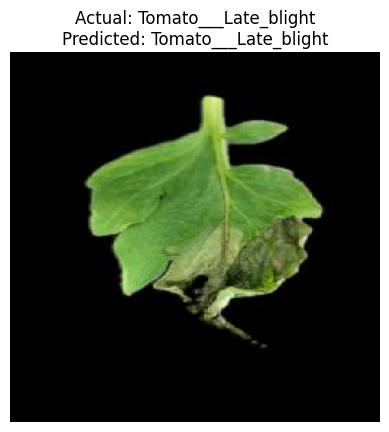

In [26]:
predict_image(model, "/kaggle/input/plantvillage-dataset/segmented/Tomato___Late_blight/081d1e25-3f06-46a1-95ef-d10a62faa80f___GHLB2 Leaf 8600_final_masked.jpg")